In [32]:
import numpy as np
import pygame
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [33]:
class Obstacle:
    def __init__(self, x, height, width, is_bird=False, image=None):
        self.x = x
        self.height = height
        self.width = width
        self.is_bird = is_bird
        self.y = 0 if is_bird else None
        self.image = image
        
class Cloud:
    def __init__(self, x, y, image):
        self.x = x
        self.y = y
        self.image = image
        self.speed = 1  # Velocidad de desplazamiento de la nube hacia la izquierda

    def update(self):
        # Mueve la nube hacia la izquierda
        self.x -= self.speed
        # Reposiciona la nube si se ha salido de la pantalla
        if self.x < -self.image.get_width():
            self.x = 800 + random.randint(50, 200)  # Reposiciona a la derecha de la pantalla
            self.y = random.randint(50, 150)  # Genera una nueva altura

In [34]:
class DinoGame:
    def __init__(self):
        pygame.init()
        self.width = 800
        self.height = 300
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Dino Game')
        
        # Cargar la imagen del piso
        self.ground_img = pygame.image.load('assets/ground.png').convert_alpha()
        self.ground_img = pygame.transform.scale(self.ground_img, (self.width, self.ground_img.get_height()))
        
        # Posición inicial del piso para el bucle
        self.ground_x1 = 0
        self.ground_x2 = self.width  # Segunda imagen a la derecha de la primera
        
        # Cargar imágenes del dinosaurio
        self.dino_run_imgs = [
            pygame.image.load('assets/dino_run1.png').convert_alpha(),
            pygame.image.load('assets/dino_run2.png').convert_alpha()
        ]
        
        self.dino_duck_imgs = [
            pygame.image.load('assets/dino_duck1.png').convert_alpha(),
            pygame.image.load('assets/dino_duck2.png').convert_alpha()
        ]
        
        # Cargar imágenes de obstáculos
        self.cactus_imgs = [
            pygame.image.load('assets/cactus1.png').convert_alpha(),
            pygame.image.load('assets/cactus2.png').convert_alpha(),
            pygame.image.load('assets/cactus3.png').convert_alpha(),
            pygame.image.load('assets/cactus4.png').convert_alpha(),
            pygame.image.load('assets/cactus5.png').convert_alpha(),
            pygame.image.load('assets/cactus6.png').convert_alpha()
        ]
        
        self.bird_imgs = [
            pygame.image.load('assets/bird1.png').convert_alpha(),
            pygame.image.load('assets/bird2.png').convert_alpha()
        ]
        
        # Cargar la imagen de la nube
        self.cloud_img = pygame.image.load('assets/cloud.png').convert_alpha()
        
        # Escalar la imagen de la nube
        self.cloud_img = pygame.transform.scale(self.cloud_img, 
                                                (int(self.cloud_img.get_width() * 3), 
                                                int(self.cloud_img.get_height() * 3)))
        
        # Crear una lista de nubes
        self.clouds = [Cloud(random.randint(800, 1600), random.randint(50, 150), self.cloud_img)
                       for _ in range(3)]  # Crea 3 nubes
        
        # Dinosaur configuration
        self.dino_height = 40
        self.dino_width = 20
        self.dino_x = 50
        self.dino_y = self.height - self.dino_run_imgs[0].get_height()
        self.dino_vel = 0
        self.jump_vel = -15
        self.gravity = 0.8
        self.is_ducking = False
        self.duck_height = self.dino_height // 2
        
        # Índices para animaciones
        self.dino_run_index = 0
        self.dino_duck_index = 0
        self.bird_index = 0
        
        # Obstaculos
        self.obstacles = []
        self.bird_heights = [self.height - 120, self.height - 80] # Altura permitida de pájaros
        
        # Espacio mínimo entre obstáculos
        self.absolute_min_spacing = 400
        self.last_obstacle_x = None
        self.max_obstacles = 2
        
        # Dificultad del juego
        self.base_speed = 5
        self.current_speed = self.base_speed
        self.speed_increment = 0.05
        self.max_speed = 12
        
        self.score = 0
        self.game_over = False
        self.clock = pygame.time.Clock()
        self.paused = False
    
    def handle_events(self):
        pygame.event.pump()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    self.paused = not self.paused
                elif event.key == pygame.K_ESCAPE:
                    pygame.quit()
                    return False
        return True
    
    def reset(self):
        self.dino_y = self.height - self.dino_height
        self.dino_vel = 0
        self.obstacles = []
        self.score = 0
        self.game_over = False
        self.paused = False
        self.current_speed = self.base_speed
        self.is_ducking = False
        self.last_obstacle_x = None
        return self._get_state()
    
    def _get_state(self):
        closest_obstacles = sorted(self.obstacles, key=lambda x: x.x)[:2]
        state = []
        
        # Añadir información de los dos obstáculos más cercanos
        for i in range(2):
            if i < len(closest_obstacles):
                obs = closest_obstacles[i]
                state.extend([
                    obs.x - self.dino_x,
                    obs.height,
                    1 if obs.is_bird else 0,
                    obs.y if obs.is_bird else self.height - obs.height
                ])
            else:
                state.extend([self.width, 0, 0, 0])
        
        # Agregar stado del dinosaurio
        state.extend([
            self.dino_y,
            self.dino_vel,
            1 if self.is_ducking else 0,
            self.current_speed
        ])
        
        return np.array(state)
    
    def _can_spawn_obstacle(self):
        if len(self.obstacles) >= self.max_obstacles:
            return False
            
        if not self.obstacles:
            return True if self.last_obstacle_x is None else False
            
        rightmost_x = max(obstacle.x for obstacle in self.obstacles)
        required_spacing = self.absolute_min_spacing + (self.current_speed * 20)
        
        return rightmost_x <= (self.width - required_spacing)
    
    def _spawn_obstacle(self):
        if not self._can_spawn_obstacle():
            return
            
        is_bird = random.random() < 0.2
        
        if is_bird:
            obstacle_img = self.bird_imgs[0]
            obstacle = Obstacle(self.width, obstacle_img.get_height(), obstacle_img.get_width(), is_bird=True, image=obstacle_img)
            obstacle.y = random.choice(self.bird_heights)
            obstacle.y = random.choice(self.bird_heights)
        else:
            obstacle_img = random.choice(self.cactus_imgs)
            obstacle = Obstacle(self.width, obstacle_img.get_height(), obstacle_img.get_width(), is_bird=False, image=obstacle_img)
        
        self.obstacles.append(obstacle)
        self.last_obstacle_x = self.width
    
    def step(self, action):
        if not self.handle_events() or self.paused:
            return self._get_state(), 0, True

        reward = 0.1
        
        if action == 1 and self.dino_y >= self.height - self.dino_height:
            self.dino_vel = self.jump_vel
            self.is_ducking = False
        elif action == 2 and self.dino_y >= self.height - self.dino_height:
            self.is_ducking = True
        else:
            self.is_ducking = False
        
        self.dino_y += self.dino_vel
        self.dino_vel += self.gravity
        
        if self.dino_y > self.height - (self.duck_height if self.is_ducking else self.dino_height):
            self.dino_y = self.height - (self.duck_height if self.is_ducking else self.dino_height)
            self.dino_vel = 0
        
        if len(self.obstacles) > 0:
            self.current_speed = min(self.max_speed, 
                                   self.base_speed + self.speed_increment * self.score)
        
        any_obstacle_passed = False
        for obstacle in self.obstacles[:]:
            obstacle.x -= self.current_speed
            if obstacle.x < -obstacle.width:
                self.obstacles.remove(obstacle)
                any_obstacle_passed = True
        
        if any_obstacle_passed:
            self.score += 1
            reward = 1.0
        
        if self._can_spawn_obstacle():
            self._spawn_obstacle()
        
        if self._check_collision():
            reward = -10.0
            self.game_over = True
        
        return self._get_state(), reward, self.game_over
    
    def _check_collision(self):
        if self.is_ducking:
            dino_img = self.dino_duck_imgs[0]
        else:
            dino_img = self.dino_run_imgs[0]
        dino_rect = dino_img.get_rect(topleft=(self.dino_x, self.dino_y))
        
        for obstacle in self.obstacles:
            obstacle_rect = obstacle.image.get_rect()
            if obstacle.is_bird:
                obstacle_rect.topleft = (obstacle.x, obstacle.y)
            else:
                obstacle_rect.bottomleft = (obstacle.x, self.height)

            if dino_rect.colliderect(obstacle_rect):
                return True
        return False
    
    def render(self):
        self.screen.fill((255, 255, 255))
        
        # Dibujar las nubes en el fondo
        for cloud in self.clouds:
            cloud.update()
            self.screen.blit(cloud.image, (cloud.x, cloud.y))
            
        # Dibujar el piso con desplazamiento infinito
        self.ground_x1 -= self.current_speed
        self.ground_x2 -= self.current_speed
        
        # Si una imagen del piso sale de la pantalla, reubicarla al extremo derecho
        if self.ground_x1 <= -self.width:
            self.ground_x1 = self.width
        if self.ground_x2 <= -self.width:
            self.ground_x2 = self.width

        # Dibujar ambas imágenes del piso para crear el efecto de bucle
        self.screen.blit(self.ground_img, (self.ground_x1, self.height - self.ground_img.get_height()))
        self.screen.blit(self.ground_img, (self.ground_x2, self.height - self.ground_img.get_height()))
        
        # Actualizar índice de animación del dinosaurio
        if self.is_ducking:
            self.dino_duck_index = (self.dino_duck_index + 0.2) % len(self.dino_duck_imgs)
            dino_img = self.dino_duck_imgs[int(self.dino_duck_index)]
        else:
            self.dino_run_index = (self.dino_run_index + 0.2) % len(self.dino_run_imgs)
            dino_img = self.dino_run_imgs[int(self.dino_run_index)]
        
        # Dibujar al dinosaurio
        self.screen.blit(dino_img, (self.dino_x, self.dino_y))
        
        # Dibujar los obstáculos
        for obstacle in self.obstacles:
            if obstacle.is_bird:
                # Animación del ave
                self.bird_index = (self.bird_index + 0.1) % len(self.bird_imgs)
                obstacle.image = self.bird_imgs[int(self.bird_index)]
                self.screen.blit(obstacle.image, (obstacle.x, obstacle.y))
            else:
                self.screen.blit(obstacle.image, (obstacle.x, self.height - obstacle.image.get_height()))
        
        # Dibujar labels de score y velocidad
        font = pygame.font.Font(None, 36)
        score_text = font.render(f'Score: {self.score}', True, (0, 0, 0))
        speed_text = font.render(f'Speed: {self.current_speed:.1f}', True, (0, 0, 0))
        self.screen.blit(score_text, (10, 10))
        self.screen.blit(speed_text, (10, 40))
        
        if self.paused:
            pause_text = font.render('PAUSED', True, (255, 0, 0))
            text_rect = pause_text.get_rect(center=(self.width/2, self.height/2))
            self.screen.blit(pause_text, text_rect)
        
        pygame.display.flip()
        self.clock.tick(60)

In [35]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)
        
        # Modelo y modelo objetivo
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # Actualiza modelo objetivo periódicamente
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Selección de acción: exploración vs. explotación
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state)
            return torch.argmax(act_values).item()

    def replay(self, batch_size):
        # Actualiza el modelo con batch de memoria
        if len(self.memory) < batch_size:
            return None
        
        minibatch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([t[0] for t in minibatch])
        actions = torch.LongTensor([t[1] for t in minibatch])
        rewards = torch.FloatTensor([t[2] for t in minibatch])
        next_states = torch.FloatTensor([t[3] for t in minibatch])
        dones = torch.FloatTensor([t[4] for t in minibatch])
        
        current_q = self.model(states).gather(1, actions.unsqueeze(1))
        
        with torch.no_grad():
            max_next_q = self.target_model(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * max_next_q

        loss = F.mse_loss(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Decae epsilon más lentamente
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Listas para almacenar métricas
episode_rewards = []
episode_losses = []
episode_epsilons = []
episode_lengths = []

def train_dino():
    env = DinoGame()
    state_size = 12
    action_size = 3
    agent = DQNAgent(state_size, action_size)
    batch_size = 64
    episodes = 1000
    best_score = -float('inf')

    try:
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            total_loss = 0
            steps_in_episode = 0
            step = 0

            while not env.game_over:
                action = agent.act(state)
                next_state, reward, done = env.step(action)
                
                # Premios incrementales por mantenerse vivo
                if not done:
                    reward += 0.05
                    
                # Penalización por acciones repetitivas en el mismo estado
                if state.tolist() == next_state.tolist() and reward == 0.1:
                    reward = -0.2  

                total_reward += reward
                agent.remember(state, action, reward, next_state, done)

                # Llama replay() con menor frecuencia
                if len(agent.memory) >= batch_size:
                    loss = agent.replay(batch_size)
                    if loss is not None:
                        total_loss += loss
                        step += 1
                
                state = next_state
                env.render()
                steps_in_episode += 1

                if done:
                    agent.update_target_model()
                    
            # Calcular pérdida promedio por episodio
            avg_loss = total_loss / step if step > 0 else 0
            episode_rewards.append(total_reward)
            episode_losses.append(avg_loss)
            episode_epsilons.append(agent.epsilon)
            episode_lengths.append(steps_in_episode)

            # Guardar modelo si tiene un mejor puntaje
            if total_reward > best_score:
                best_score = total_reward
                torch.save(agent.model.state_dict(), 'best_dino_model.pth')
                print(f"Mejor modelo guardado con puntaje: {total_reward}")
            
            print(f"Episodio: {episode + 1}, Puntaje: {total_reward}, Epsilon: {agent.epsilon}")
            
            if episode % 50 == 0:
                pd.DataFrame({
                'episode': range(1, len(episode_rewards) + 1),
                'episode_rewards': episode_rewards,
                'episode_losses': episode_losses,
                'episode_epsilons': episode_epsilons,
                'episode_lengths': episode_lengths
            }).to_csv('dino_metrics.csv', index=False)
            
    except KeyboardInterrupt:
        print("Entrenamiento interrumpido")
        
    finally:
        pygame.quit()

if __name__ == "__main__":
    train_dino()

Mejor modelo guardado con puntaje: 27.799999999999834
Episodio: 1, Puntaje: 27.799999999999834, Epsilon: 0.3976004408064698
Episodio: 2, Puntaje: 13.699999999999953, Epsilon: 0.17919120740315364
Episodio: 3, Puntaje: 27.04999999999984, Epsilon: 0.05327239673939179
Episodio: 4, Puntaje: 12.649999999999963, Epsilon: 0.049911691230058335
Episodio: 5, Puntaje: 12.799999999999962, Epsilon: 0.049911691230058335
Entrenamiento interrumpido


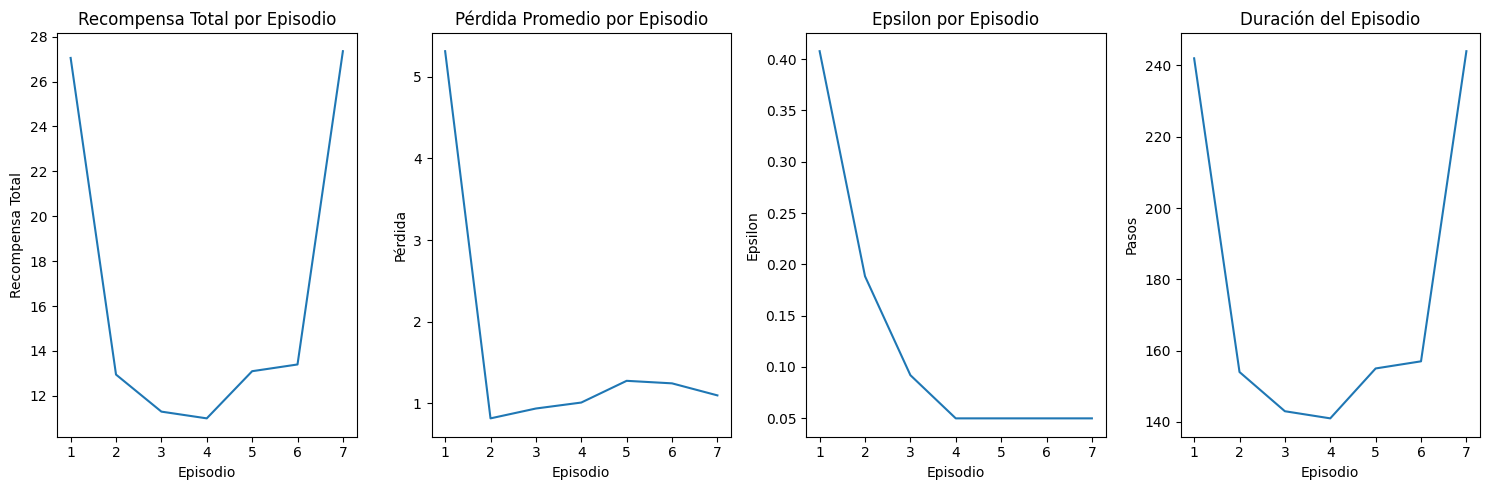

In [ ]:
import matplotlib.pyplot as plt

# Cargar el archivo CSV con las métricas
df = pd.read_csv('dino_metrics.csv')

# Extraer las columnas para cada métrica
episodes = df['episode']
episode_rewards = df['episode_rewards']
episode_losses = df['episode_losses']
episode_epsilons = df['episode_epsilons']
episode_lengths = df['episode_lengths']

# Graficar las métricas
plt.figure(figsize=(15,5))

plt.subplot(1, 4, 1)
plt.plot(episodes, episode_rewards)
plt.title('Recompensa Total por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')

plt.subplot(1, 4, 2)
plt.plot(episodes, episode_losses)
plt.title('Pérdida Promedio por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Pérdida')

plt.subplot(1, 4, 3)
plt.plot(episodes, episode_epsilons)
plt.title('Epsilon por Episodio')
plt.xlabel('Episodio')
plt.ylabel('Epsilon')

plt.subplot(1, 4, 4)
plt.plot(episodes, episode_lengths)
plt.title('Duración del Episodio')
plt.xlabel('Episodio')
plt.ylabel('Pasos')

plt.tight_layout()
plt.show()

In [38]:
import shap
env = DinoGame()

# 1. Cargar el modelo guardado
state_size = 12  # Asegúrate de que sea el tamaño correcto
action_size = 3  # Asegúrate de que sea el tamaño correcto
agent = DQNAgent(state_size, action_size)  # Asegúrate de que coincida con la arquitectura del modelo guardado
agent.model.load_state_dict(torch.load('best_dino_model.pth'))
agent.model.eval()  # Poner el modelo en modo evaluación

# 2. Crear un conjunto de datos representativo de estados
# Por ejemplo, simulando algunos estados aleatorios del entorno DinoGame
sample_states = []
for _ in range(100):  # Obtener 100 ejemplos de estados
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Toma una acción aleatoria
        next_state, _, done = env.step(action)
        sample_states.append(state)
        state = next_state
sample_states = torch.FloatTensor(sample_states[:100])  # Convertir a tensor y limitar a 100 estados

# 3. Configurar SHAP DeepExplainer con el modelo cargado
explainer = shap.DeepExplainer(agent.model, sample_states)

# 4. Calcular los valores SHAP
shap_values = explainer.shap_values(sample_states)

# 5. Visualizar los valores SHAP para cada acción
for i in range(agent.action_size):
    print(f"Valores SHAP para la acción {i}")
    shap.summary_plot(shap_values[i], sample_states.numpy(), feature_names=['Feature_1', 'Feature_2', ...])  # Reemplaza con los nombres de tus características


C:\Users\Pablo Zamora\AppData\Local\Temp\ipykernel_10424\398271534.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.model.load_state_dict(torch.load('best_dino_mode

AttributeError: 'DinoGame' object has no attribute 'action_space'